# Projet TAL - RI
_Charlotte Kruzic & Zoé Marquis_
# Étape 1

In [1]:
!pip install pandas unidecode

Defaulting to user installation because normal site-packages is not writeable


In [2]:

# Imports nécessaires

%matplotlib inline

# Suppression de l'affichage des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')

import string
import time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn import model_selection
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
import seaborn as sns
sns.set_theme(style="darkgrid")

set_config(display='diagram')

nltk.download('stopwords')
nltk.download('punkt')

2024-04-29 10:31:51.097000: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 10:31:51.127348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 10:31:51.565504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /home/zoe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zoe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Charger les données & exploration

In [3]:
df_train = pd.read_csv("train.tsv", sep='\t')

In [4]:
df_train.head()

,category,headline,text,url
0,sports,"L'Ouganda à l'assaut des ""fimbu"" de la RDC","L'Ouganda, placé 79e au classement FIFA le 4 a...",https://www.bbc.com/afrique/sports-48730747
1,business,Stopper la détérioration de l’environnement po...,La responsable de la biodiversité des Nations ...,https://www.bbc.com/afrique/articles/cevdz4xrp42o
2,sports,Coupe d'Afrique des nations 2022 : le sélectio...,"Le sélectionneur de la Sierra Leone, John Keis...",https://www.bbc.com/afrique/region-59881445
3,business,Tissus africains : pourquoi les teintureries h...,"Depuis plus de six siècles, une vaste zone sit...",https://www.bbc.com/afrique/region-61202726
4,business,Les revenus pendant la pandémie des dix hommes...,"Pendant la pandémie de coronavirus, la richess...",https://www.bbc.com/afrique/monde-55812018


In [5]:
print(df_train.columns)

Index(['category', 'headline', 'text', 'url'], dtype='object')


### Nettoyer les données 

In [6]:
# identifier les valeurs manquantes
valeurs_manquantes = df_train.isnull().sum()
print(valeurs_manquantes) 
# pas de valeur manquante

category    0
headline    0
text        0
url         0
dtype: int64


In [7]:
# identifier les lignes dupliquées
dupliquees = df_train.duplicated()
print(dupliquees.sum())
# 1 ligne dupliquée

1


In [8]:
# supprimer les lignes dupliquées
df_train = df_train.drop_duplicates()
dupliquees = df_train.duplicated()
print(dupliquees.sum())

0


In [9]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1475 entries, 0 to 1475
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1475 non-null   object
 1   headline  1475 non-null   object
 2   text      1475 non-null   object
 3   url       1475 non-null   object
dtypes: object(4)
memory usage: 57.6+ KB
None


Le jeu de données contient 1475 lignes.  
Toutes les colonnes contiennent du texte (donc il n'est pas nécessaire de traiter les données numériques).   
On s'intéresse seulement aux colonnes `headline` et `text`.

### Préparer les données pour l'apprentissage de la catégorie
à partir du titre et du texte uniquement

Séparation des données de la catégorie à prédire

In [10]:
X = df_train[['headline', 'text']]
y = df_train.category

In [11]:
X.head()

,headline,text
0,"L'Ouganda à l'assaut des ""fimbu"" de la RDC","L'Ouganda, placé 79e au classement FIFA le 4 a..."
1,Stopper la détérioration de l’environnement po...,La responsable de la biodiversité des Nations ...
2,Coupe d'Afrique des nations 2022 : le sélectio...,"Le sélectionneur de la Sierra Leone, John Keis..."
3,Tissus africains : pourquoi les teintureries h...,"Depuis plus de six siècles, une vaste zone sit..."
4,Les revenus pendant la pandémie des dix hommes...,"Pendant la pandémie de coronavirus, la richess..."


In [12]:
# afficher toutes les catégories
y.unique()

array(['sports', 'business', 'politics', 'health', 'technology'],
      dtype=object)

### Prétraitements des données

- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides

In [13]:
# def split_into_tokens_nltk(desc) :
#     return word_tokenize(desc, language='french')
# 
# # Liste des mots vides de NLTK + signes de ponctuation
# nltk_stopwords = stopwords.words('french')+list(string.punctuation)
# # +['``'] : à essayer


# Liste des mots vides de NLTK + signes de ponctuation
nltk_stopwords = set(stopwords.words('french')) | set(string.punctuation) 

# Fonction de tokenisation personnalisée
def split_into_tokens_nltk(desc):
    tokens = word_tokenize(desc, language='french')
    tokens = [token.lower() for token in tokens if token.lower() not in nltk_stopwords]
    return tokens

On va essayer plusieurs prétraitements différents supplémentaires dont : 
- Lemmatisation
- Désuffixation
- N-grammes

In [14]:
stemmer = SnowballStemmer(language='french')

def stemming(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def stemming_transformer(X):
    return X.apply(stemming)

In [15]:
# def lemmatize_text(text):
#     # modèle français de Spacy
#     nlp = spacy.load("fr_core_news_sm")
#     lemmatized_text = ' '.join([token.lemma_ for token in nlp(text)])
#     return lemmatized_text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text, language='french')
    lemmatized_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    return lemmatized_text

def lemmatization_transformer(X):
    return X.apply(lemmatize_text)

On va essayer 3 types de traits : 
- TF-IDF (avec différentes fréquences)
- Sac de mots (avec différentes fréquences)
- Informations statistiques : longueur en nombre de caractères et nombre approximatif de phrases

In [16]:
def text_stats(descriptions):
    return [{"length": len(text), "num_sentences": text.count(".")}
            for text in descriptions]
    
text_stats_transformer = FunctionTransformer(text_stats)
text_stats_vectorizer = DictVectorizer(sparse=False)
min_max_scaler = MinMaxScaler()    

In [17]:
tfidf_001 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True, 
                            # stop_words=nltk_stopwords,
                            min_df = 0.01)
bow_001 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                          lowercase=True,
                          # stop_words=nltk_stopwords,
                          min_df=0.01)

tfidf_001_ngram2 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True, 
                            # stop_words=nltk_stopwords,
                            min_df = 0.01,
                            ngram_range=(1, 2)
                            )
bow_001_ngram2 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                          lowercase=True,
                          # stop_words=nltk_stopwords,
                          ngram_range=(1, 2),
                          min_df=0.01)

tfidf_001_ngram3 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True, 
                            # stop_words=nltk_stopwords,
                            min_df = 0.01,
                            ngram_range=(1, 3)
                            )
bow_001_ngram3 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                          lowercase=True,
                          # stop_words=nltk_stopwords,
                          ngram_range=(1, 3),
                          min_df=0.01)

tfidf_001_ngram4 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True, 
                            # stop_words=nltk_stopwords,
                            min_df = 0.01,
                            ngram_range=(1, 4)
                            )
bow_001_ngram4 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                          lowercase=True,
                          # stop_words=nltk_stopwords,
                          ngram_range=(1, 4),
                          min_df=0.01)

tfidf_010 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True, 
                            # stop_words=nltk_stopwords,
                            min_df = 0.1)
bow_010 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                          lowercase=True,
                          # stop_words=nltk_stopwords,
                          min_df=0.1)

tfidf_005 = TfidfVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                            lowercase=True, 
                            # stop_words=nltk_stopwords,
                            min_df = 0.05)
bow_005 = CountVectorizer(tokenizer=split_into_tokens_nltk,
                            token_pattern=None,
                          lowercase=True,
                         #  stop_words=nltk_stopwords,
                          min_df=0.05)

### Modèles

In [18]:
models = [
    ('Baseline', DummyClassifier(strategy='most_frequent')),
    ('Mutinomial NB', MultinomialNB()),
    ('CART', DecisionTreeClassifier()),
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Random forest', RandomForestClassifier()),
    ('SVM', SVC(kernel='rbf')),
]

### Évaluation

Validation croisée à 5 plis

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                    random_state=3, shuffle=True)

In [20]:
stratkfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [21]:
def evaluate(modele, trait):
    model_pipeline = make_pipeline(trait, modele)
    y_pred = model_selection.cross_val_predict(model_pipeline, X_train, y_train,
                                               cv=stratkfold, n_jobs=-1)
    return y_pred

In [22]:
def run(chaines, modeles):
    classification_reports = {}

    for identifiant, colonne_transformateur in chaines:
        classification_reports[identifiant] = {}
        
        for name, model in models :
            y_pred = evaluate(model, trait=colonne_transformateur)
            
            report = classification_report(y_train, y_pred, output_dict=True)
            
            classification_reports[identifiant][name] = {
                "accuracy" : report["accuracy"],
                "f1-score" : report["macro avg"]["f1-score"],
                "precision" : report["macro avg"]["precision"],
                "recall" : report["macro avg"]["recall"],
            }
        
    return classification_reports

### Visualiser pour comparer

In [23]:
def afficher_chaines(reports):
    for chaine_num, chaine_data in reports.items():
        fig, axs = plt.subplots(2, 2, figsize=(8, 6))
        fig.suptitle(chaine_num) 

        metrics = ['accuracy', 'f1-score', 'precision', 'recall']

        for ax, metric in zip(axs.flatten(), metrics):
            model_names = list(chaine_data.keys())
            metric_values = [model_data[metric] for model_data in chaine_data.values()]
            
            
            mean_metric = np.mean(metric_values)
            max_metric = np.max(metric_values)
            
            ax.axvline(mean_metric, color='r', linestyle='--', label=f'Mean ({mean_metric:.2f})')
            ax.axvline(max_metric, color='g', linestyle='--', label=f'Max ({max_metric:.2f})')
            

            ax.barh(model_names, metric_values, color='b')
            ax.set_title(metric.upper()) 
            ax.set_xlabel(metric.capitalize())  
            ax.set_ylabel('Modèles')  
            ax.invert_yaxis()  
            ax.set_xlim(0, 1)
            
            ax.legend()
            
        plt.tight_layout()
        plt.show()

In [24]:
def comparer_chaines(reports):
    metrics = ['accuracy', 'f1-score', 'precision', 'recall']
    metric_values = {metric: [] for metric in metrics}

    for chaine_num, chaine_data in reports.items():
        longueur = len(chaine_data.keys())
        for model, values in chaine_data.items():
            for metric in metrics:
                metric_values[metric].append((chaine_num, model, values[metric]))
                

    for metric in metrics:
        fig, axs = plt.subplots(2, 2, figsize=(8, 6))
        fig.suptitle(f'Comparaison de la métrique {metric.capitalize()} par modèle')  # Titre de la figure

        for i, ax in enumerate(axs.flat):
            values = metric_values[metric][i*longueur:(i+1)*longueur]

            chaine_names = [value[0] for value in values]
            model_names = [value[1] for value in values]
            metric_scores = [value[2] for value in values]
            
            mean_metric_score = np.mean(metric_scores)
            max_metric_score = np.max(metric_scores)
            
            ax.axvline(mean_metric_score, color='r', linestyle='--', label=f'Moyenne ({mean_metric_score:.2f})')
            ax.axvline(max_metric_score, color='g', linestyle='--', label=f'Maximum ({max_metric_score:.2f})')

            ax.barh(model_names, metric_scores, color='b')
            ax.set_title(chaine_names[0])  
            ax.set_xlabel(chaine_names[0]) 
            ax.set_ylabel('Chaines')  
            ax.invert_yaxis() 
            ax.set_xlim(0, 1)
            ax.legend()
            
        plt.tight_layout()

    plt.show()


## Premières chaines

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides

Et on utilise les traits suivants :

| n° | headline | text |
| --- | --- | --- |
| 1 | tf-idf (fréquence = 0.01) | tf-idf (fréquence = 0.01) | 
| 2 | sac de mots (fréquence = 0.01) | sac de mots (fréquence = 0.01) | 
| 3 | tf-idf (fréquence = 0.01) |  sac de mots (fréquence = 0.01) | 
| 4 | sac de mots (fréquence = 0.01) |  tf-idf (fréquence = 0.01) | 

In [25]:
chaines = [
    ('chain1', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_tfidf_001', tfidf_001, 'text'),
        ]
    )),
    
    ('chain2', ColumnTransformer(
        [
            ('headline_bow_001', bow_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
        ]
    )),
    
    ('chain3', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
        ]
    )),
    
    ('chain4', ColumnTransformer(
        [
            ('headline_bow_001', bow_001, 'headline'),
            ('text_tfidf_001', tfidf_001, 'text'),
        ]
    )),
]


In [26]:
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

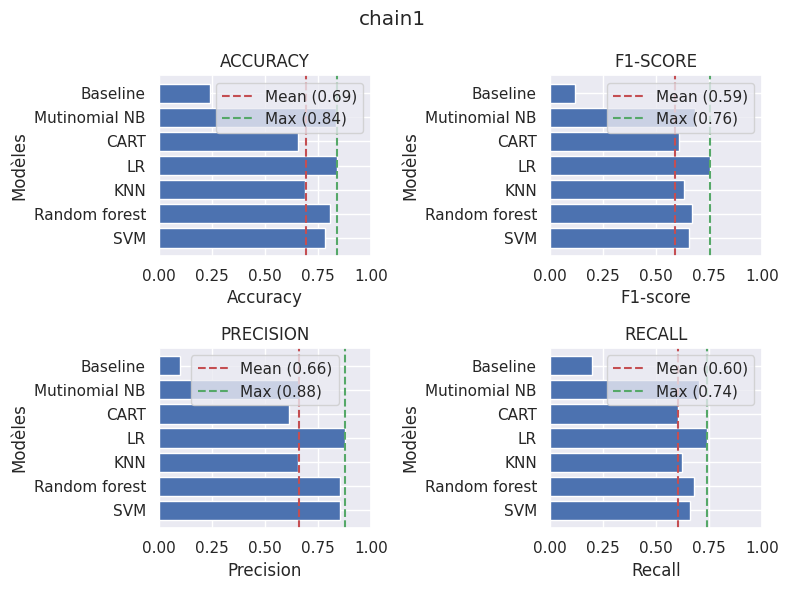

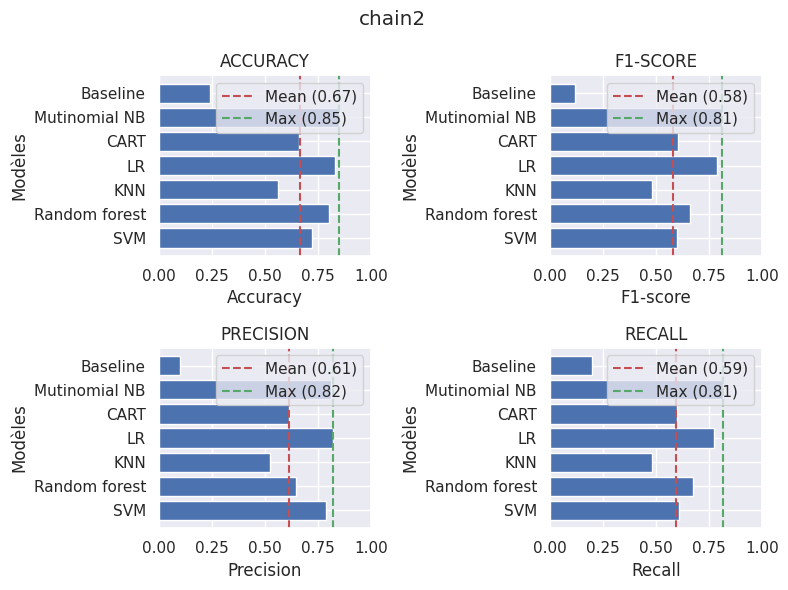

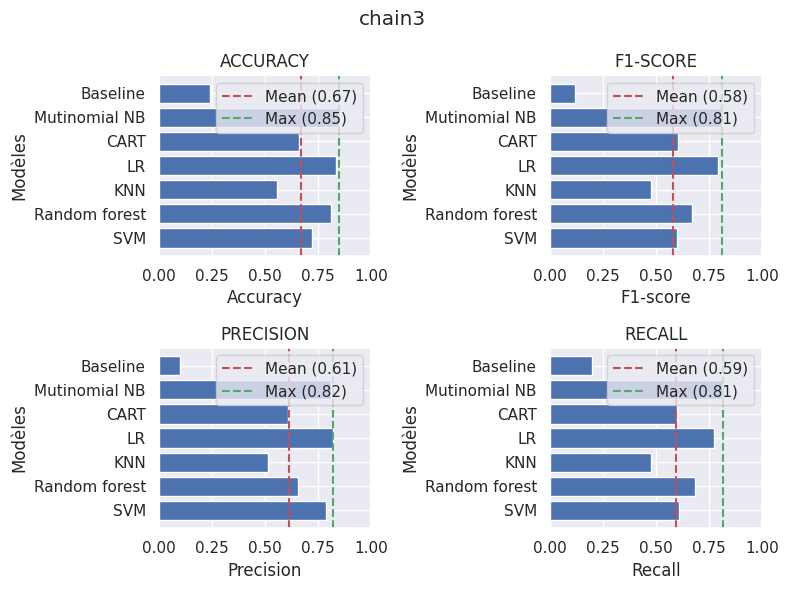

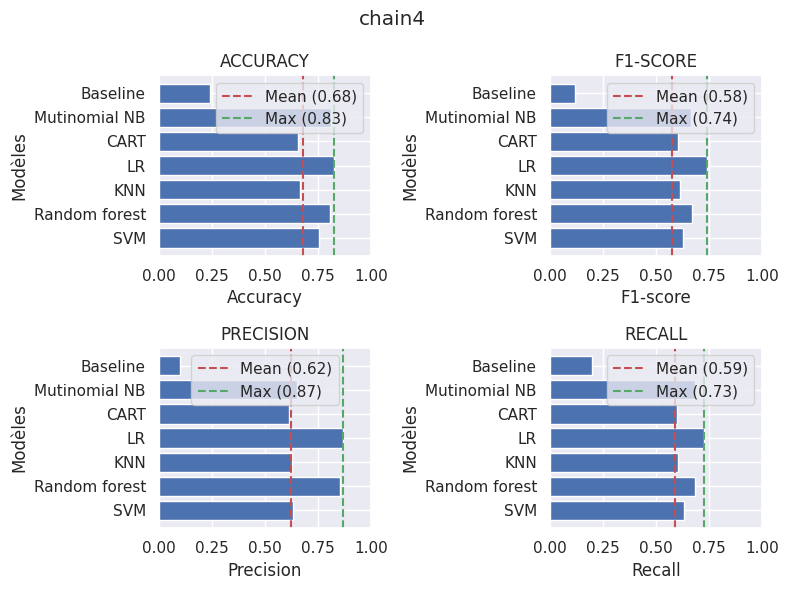

In [ ]:
afficher_chaines(classification_reports)

On s'aperçoit tout de suite que les 4 meilleurs modèles sont (presque) à chaque fois 
- Multinomial NB
- LR (Régression Logistique)
- Random forest
- SVM

Nous redéfinissons donc la liste des modèles que nous utiliserons : 

In [28]:
models = [
    ('Mutinomial NB', MultinomialNB()),
    ('LR', LogisticRegression()),
    ('Random forest', RandomForestClassifier()),
    ('SVM', SVC(kernel='rbf')),
]

In [29]:
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

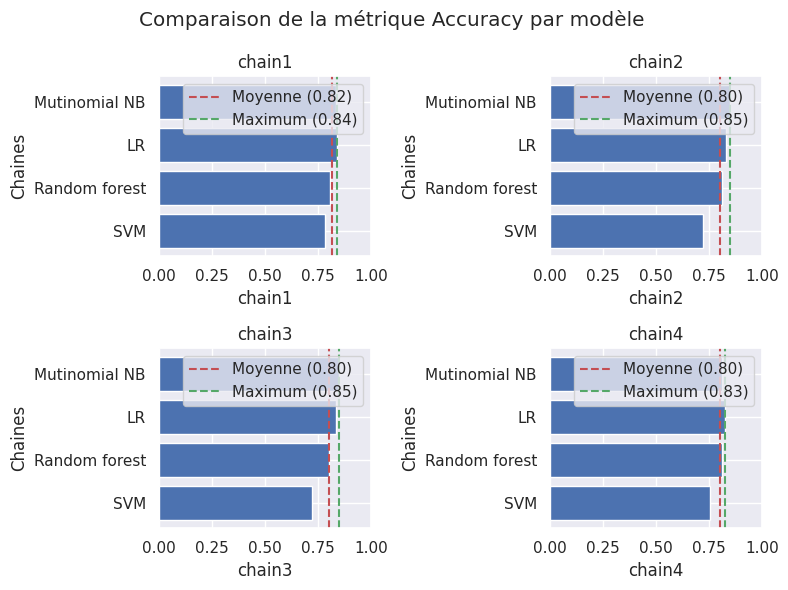

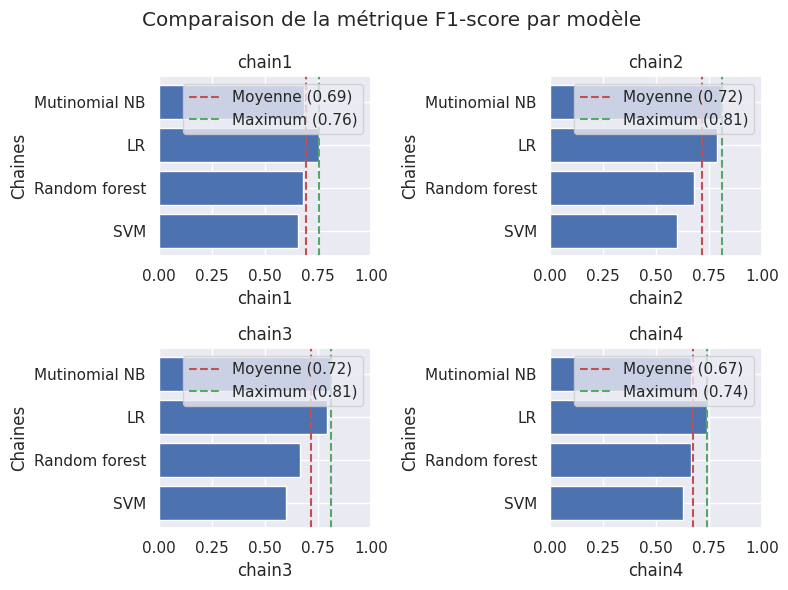

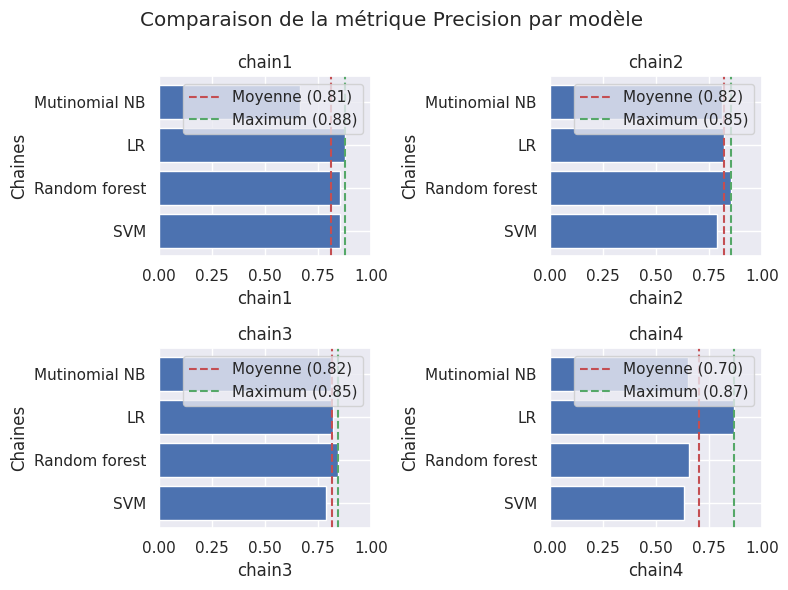

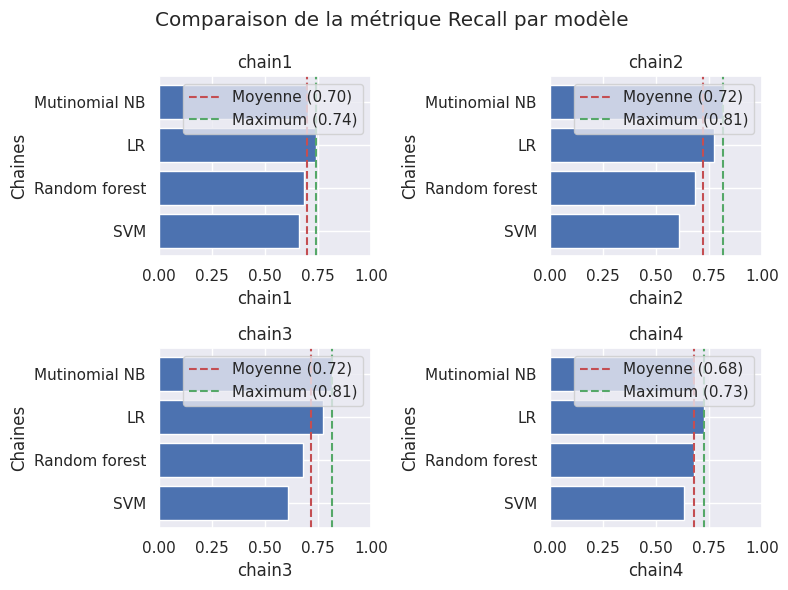

In [30]:
comparer_chaines(classification_reports)

On élimine les chaines 1 et 4 car elles ont un F1-score moins bons.

Essayons maintenant d'ajouter les traits d'informations statistiques.

## Deuxièmes chaines

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides

Et on utilise les traits suivants :

| n° | headline | text |
| --- | --- | --- |
| 2 | sac de mots (fréquence = 0.01) | sac de mots (fréquence = 0.01) | 
| 3 | tf-idf (fréquence = 0.01) |  sac de mots (fréquence = 0.01) | 
| 5 | sac de mots (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 6 | tf-idf (fréquence = 0.01) |  sac de mots (fréquence = 0.01) + informations statistiques | 

In [31]:
chaines = [
    ('chain2', ColumnTransformer(
        [
            ('headline_bow_001', bow_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
        ]
    )),
    
    ('chain3', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
        ]
    )),
    
    ('chain5', ColumnTransformer(
        [
            ('headline_bow_001', bow_001, 'headline'),
            ('text_bow_001', bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain6', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
]


In [32]:
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

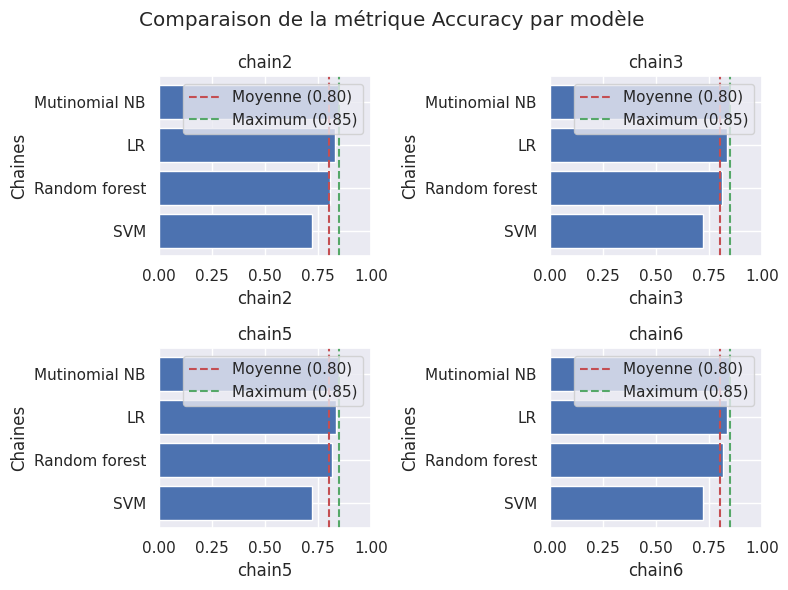

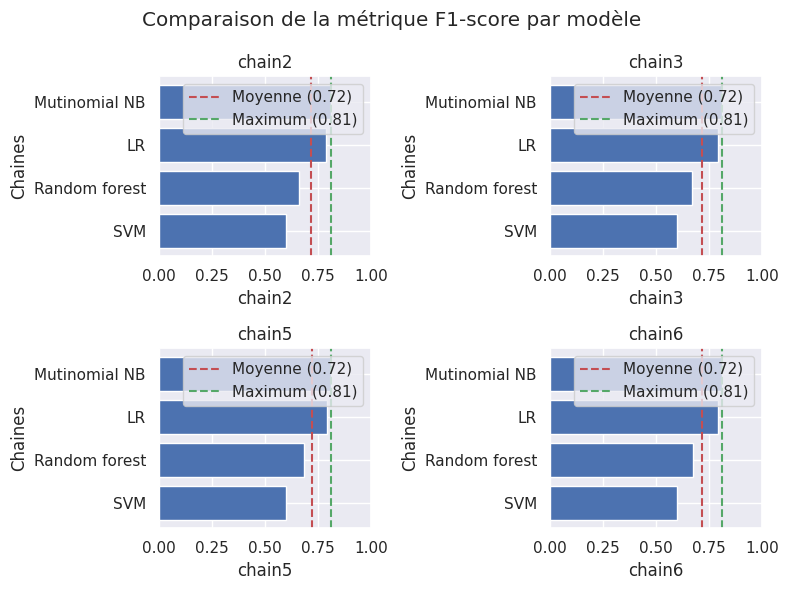

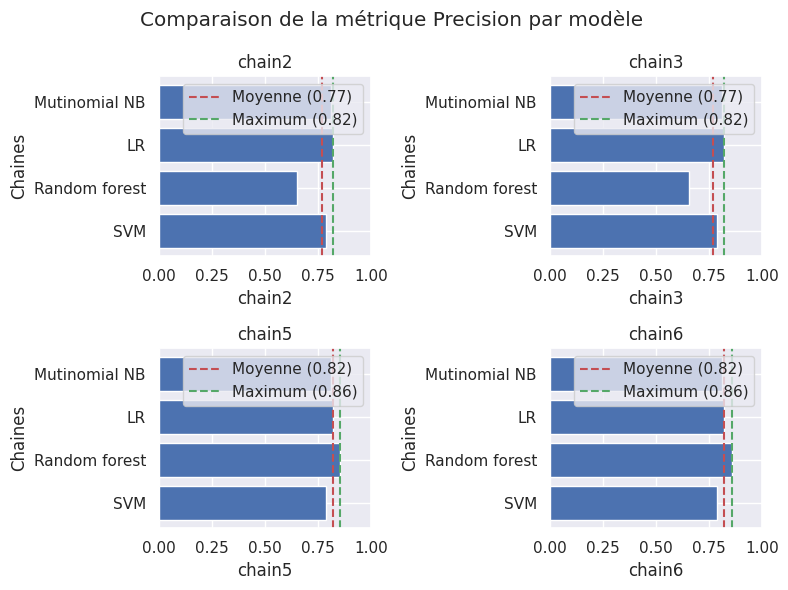

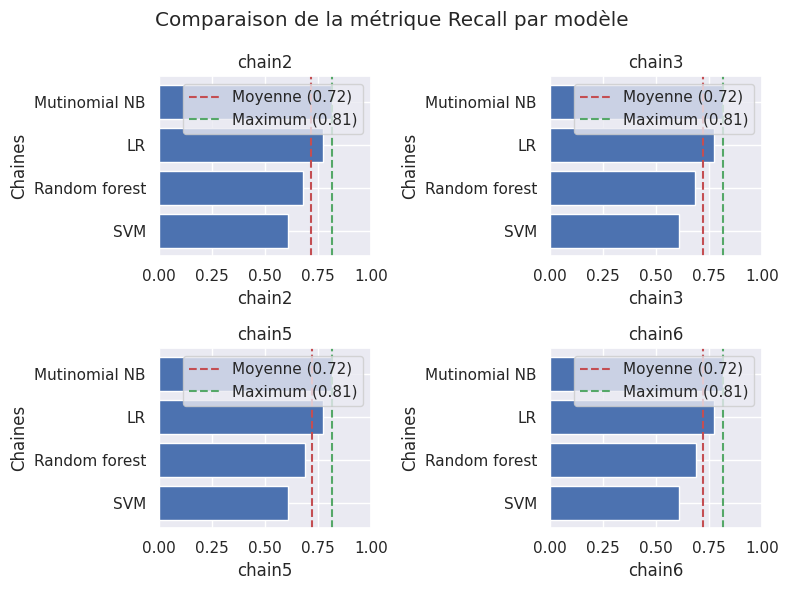

In [33]:
comparer_chaines(classification_reports)

Les mesures sont peu impactées par ce changement de traits.  
On garde la chaine 6 pour la suite car elle est légèrement meilleure lorsqu'il s'agit de Precision Rappel (pour la valeur maximale).   
On supprime aussi le modèle SVM qui n'est pas le plus performant.

In [34]:
models = [
    ('Mutinomial NB', MultinomialNB()),
    ('LR', LogisticRegression()),
    ('Random forest', RandomForestClassifier()),
]

## Troisièmes chaines

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- **N-grammes**

Et on utilise les traits suivants :

| n° | headline | text | n-gramme |
| --- | --- | --- | --- |
| 6 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 7 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 2 |
| 8 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 3 |
| 9 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 4 |

In [35]:
chaines = [
    ('chain6', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain7', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001_ngram2, 'headline'),
            ('text_bow_001',  bow_001_ngram2, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain8', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001_ngram3, 'headline'),
            ('text_bow_001',  bow_001_ngram3, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain9', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001_ngram4, 'headline'),
            ('text_bow_001',  bow_001_ngram4, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]


In [36]:
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

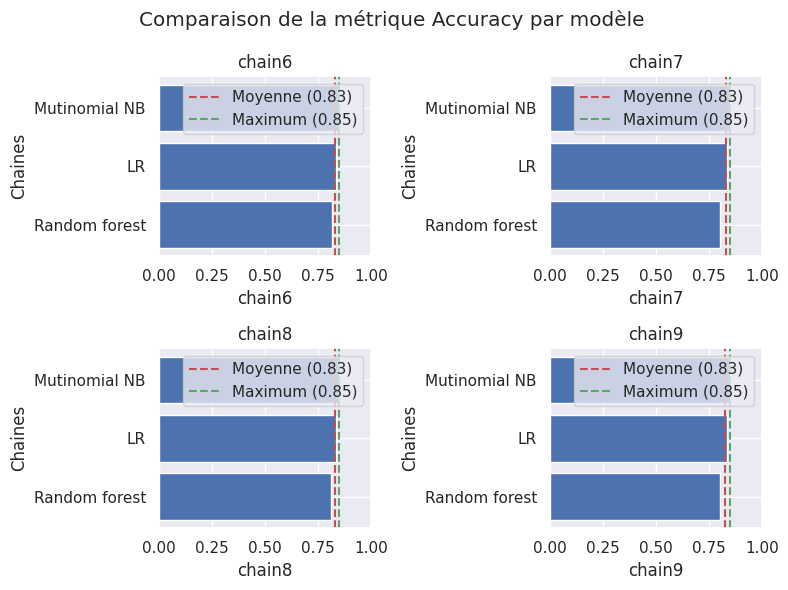

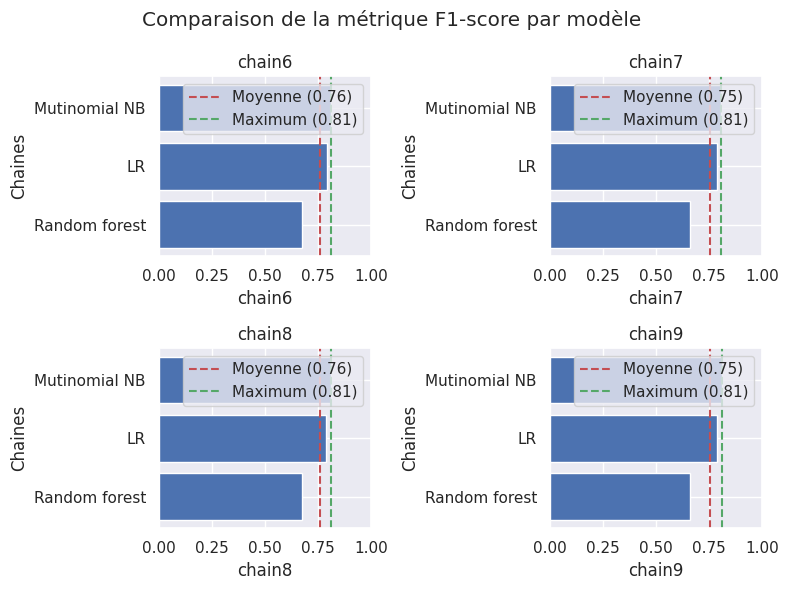

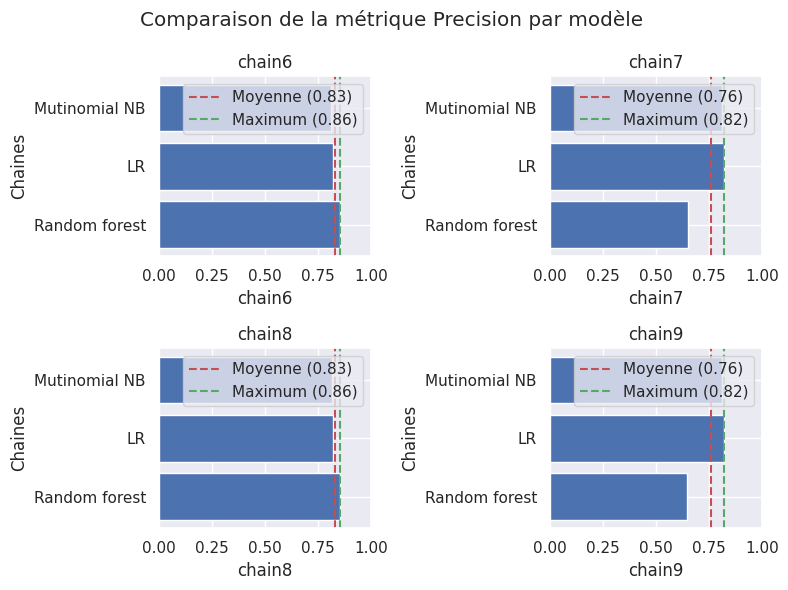

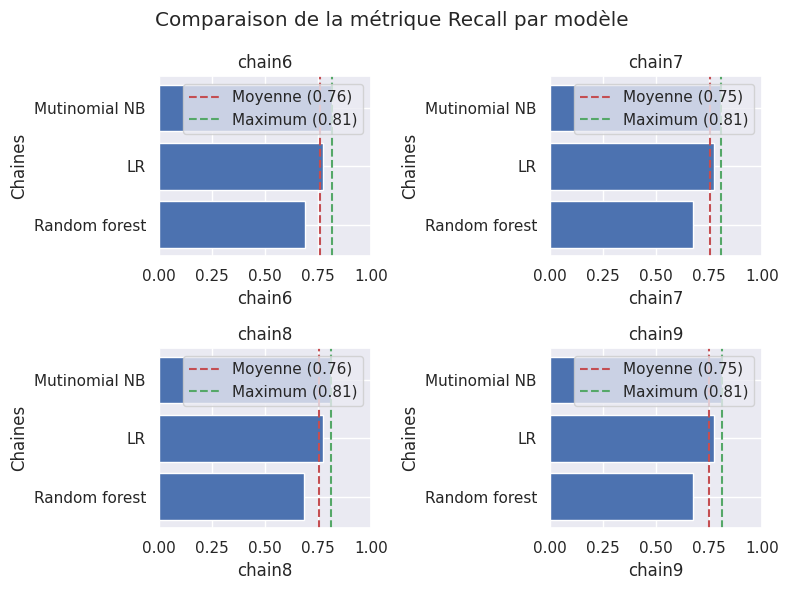

In [37]:
comparer_chaines(classification_reports)

On garde la chaine 6 qui a les mêmes mesures que la chaine 9, supérieures aux autres chaines en terme de Précision, identiques pour les autres mesures.

On essaye les n-grammes lorsq'uon utilise TF-IDF pour le texte.

In [38]:
chaines = [
    ('chain6', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain7tfidf', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001_ngram2, 'headline'),
            ('text_bow_001',  tfidf_001_ngram2, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain8tfidf', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001_ngram3, 'headline'),
            ('text_bow_001',  tfidf_001_ngram3, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain9tfidf', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001_ngram4, 'headline'),
            ('text_bow_001',  tfidf_001_ngram4, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]


In [39]:
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

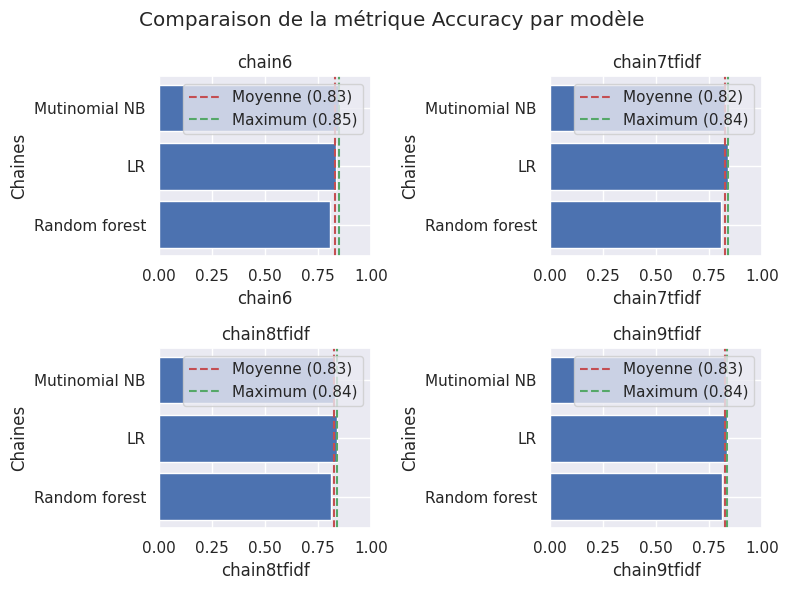

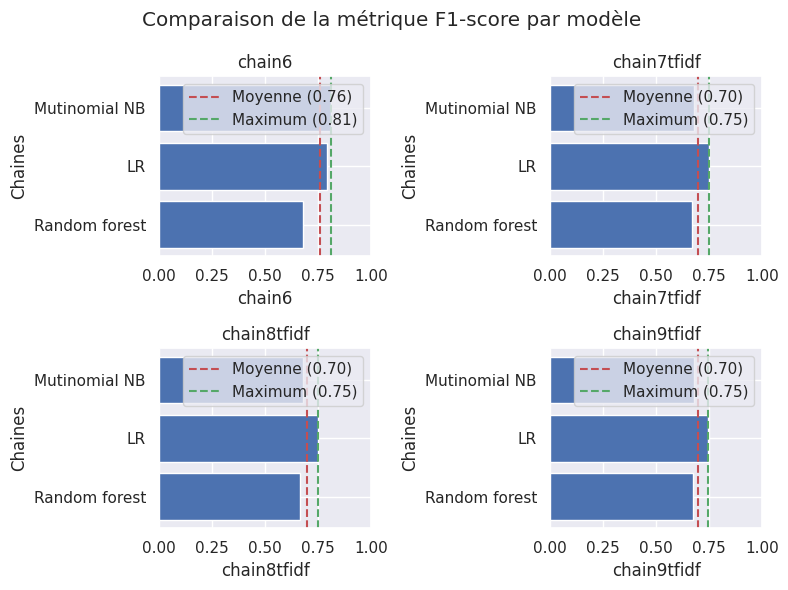

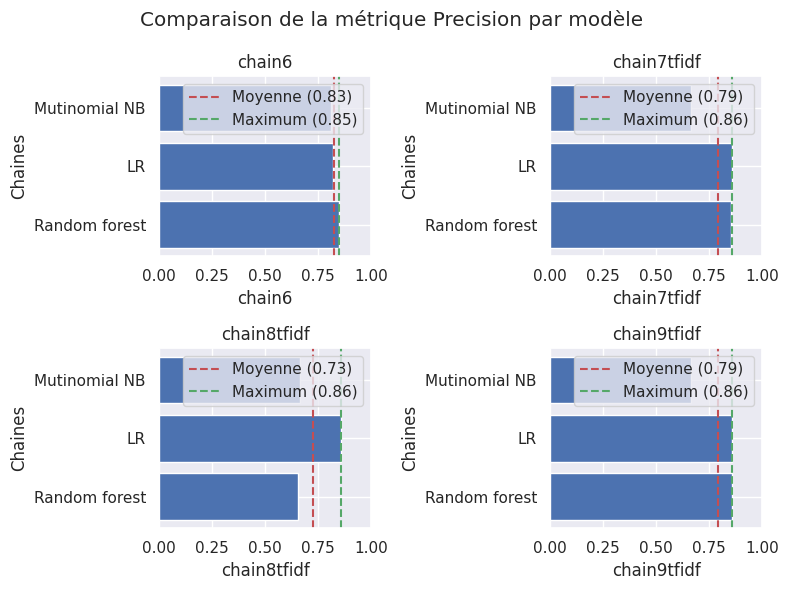

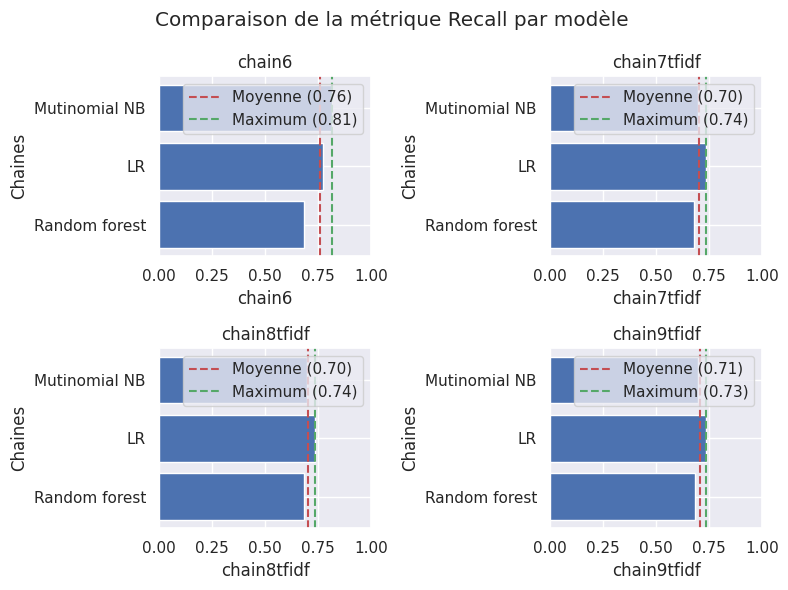

In [40]:
comparer_chaines(classification_reports)

On garde la chaine 6 : l'*accuracy* est identique mais le F1-score est moins bon.

## Quatrièmes chaines 

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- **Fréquences** 

Et on utilise les traits suivants :

| n° | headline | text | 
| --- | --- | --- | 
| 6 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 10 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.1) + informations statistiques | 
| 11 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.1) + informations statistiques | 
| 12 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.01) + informations statistiques | 

In [41]:
chaines = [
    ('chain6', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain10', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_010, 'headline'),
            ('text_bow_001',  bow_010, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain11', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_010, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain12', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_010, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]


In [42]:
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

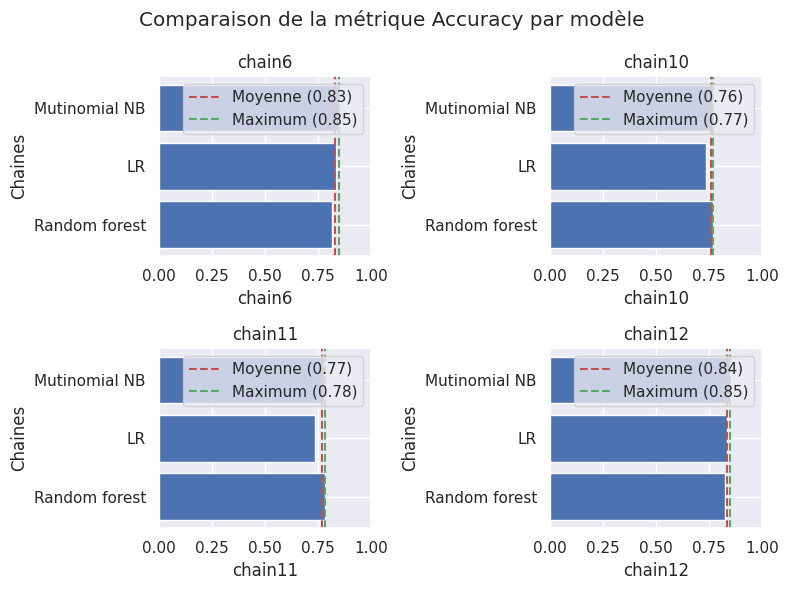

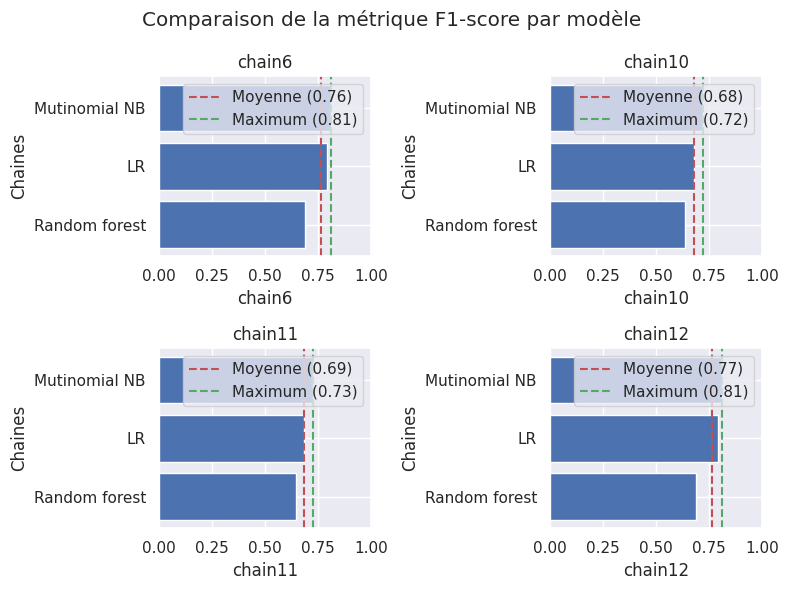

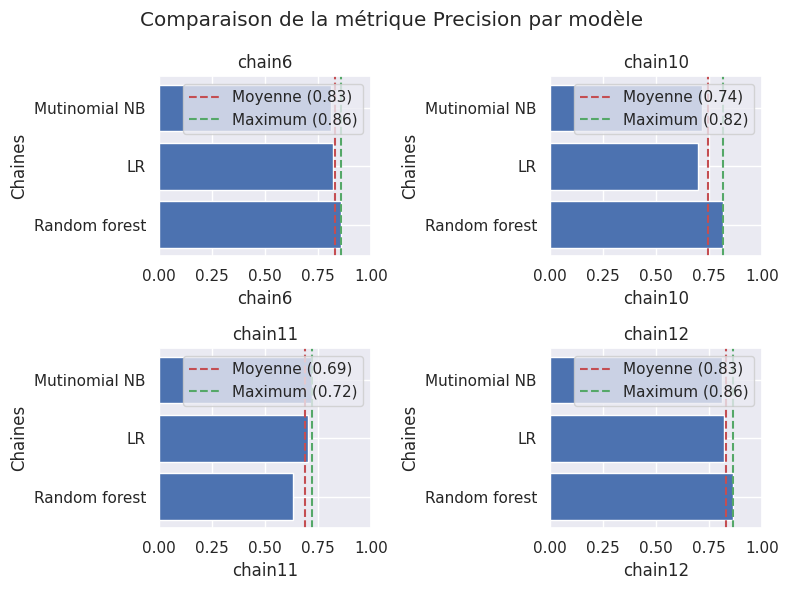

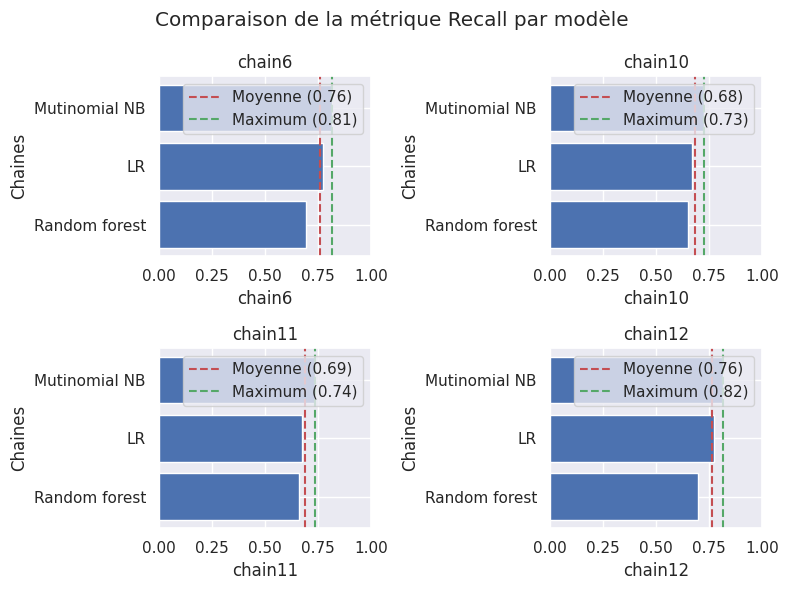

In [43]:
comparer_chaines(classification_reports)

On élimine les chaines 10 et 11 et on essaye une autre valeur pour la fréquence.

## Cinquièmes chaines 

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- **Fréquences** 

Et on utilise les traits suivants :

| n° | headline | text | 
| --- | --- | --- | 
| 6 | tf-idf (fréquence = 0.01) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 12 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.01) + informations statistiques | 
| 13 | tf-idf (fréquence = 0.05) | sac de mots (fréquence = 0.05) + informations statistiques | 
| 14 | tf-idf (fréquence = 0.1) | sac de mots (fréquence = 0.05) + informations statistiques | 

In [44]:
chaines = [
    ('chain6', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_001, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain12', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_010, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    
    ('chain13', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_005, 'headline'),
            ('text_bow_001',  bow_005, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain14', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_010, 'headline'),
            ('text_bow_001',  bow_005, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
]


In [45]:
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

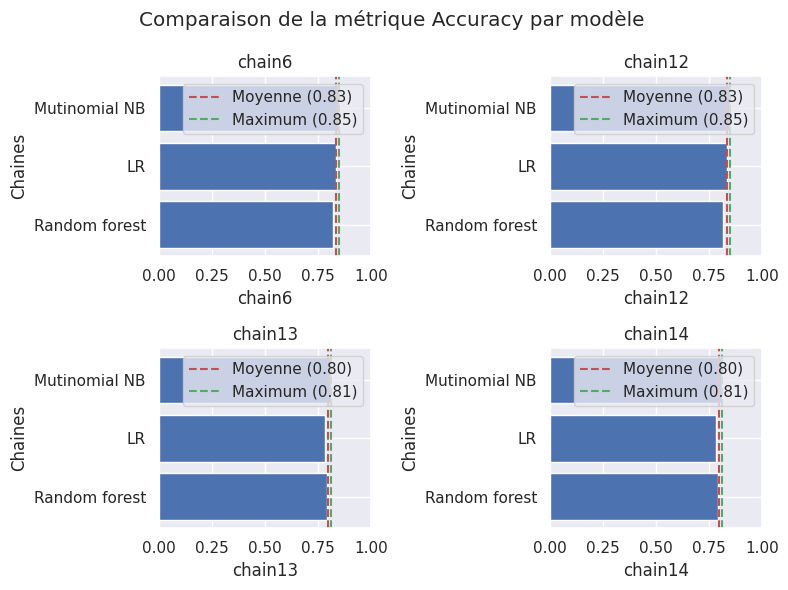

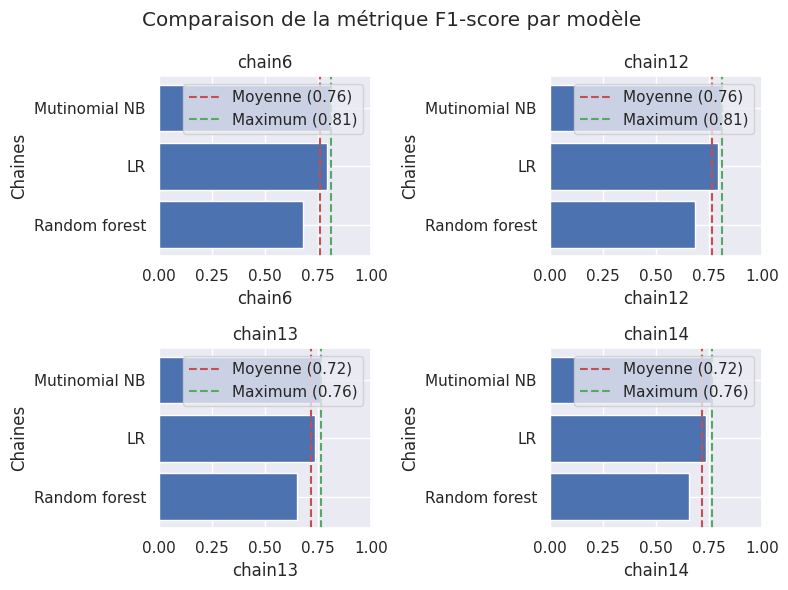

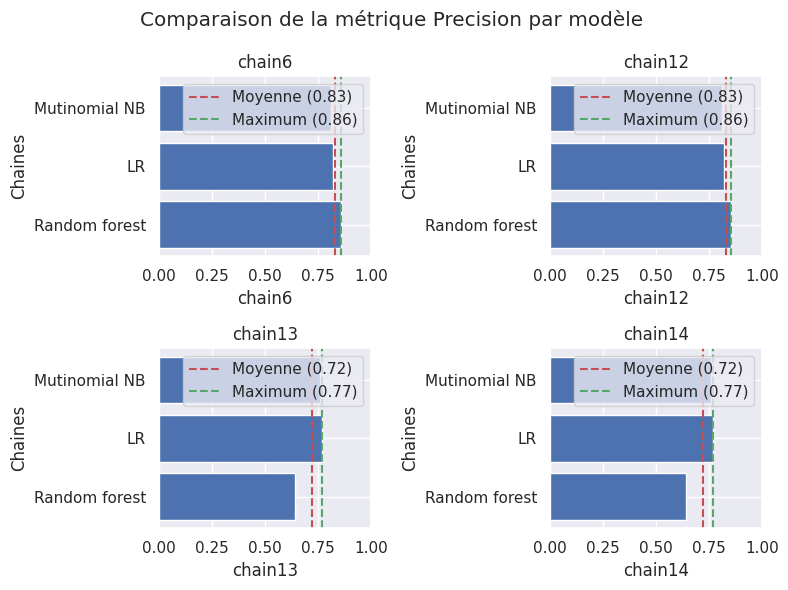

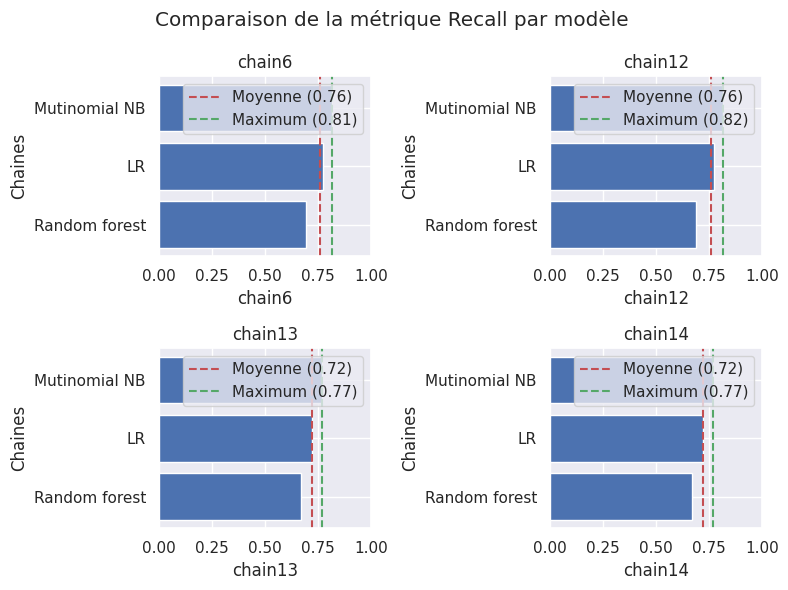

In [46]:
comparer_chaines(classification_reports)

On conserve la chaine 12 qui obtient les mêmes scores pour toutes les mesures, et est légèrement supérieure en terme de Rappel.

## Sixièmes chaines 

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- **Désuffixation**

Et on utilise les traits suivants :

| n° | headline | text | 
| --- | --- | --- | 


In [47]:
chaines = [
    ('chain12', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_010, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    ('chain15', ColumnTransformer(
        [
            ('headline_tfidf_001', 
                Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('text_stats', tfidf_010),
                 ]
                ),
                 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    ('chain16', ColumnTransformer(
        [
            ('headline_tfidf_001', tfidf_010, 'headline'),
            ('text_bow_001',  
                Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('text_stats', bow_001),
                 ]
                ),
                 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    ('chain17', ColumnTransformer(
        [
            ('headline_tfidf_001', 
                Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('text_stats', tfidf_010),
                 ]
                ),
                 'headline'),
            ('text_bow_001',  
                Pipeline(
                 [
                     ('stemming', FunctionTransformer(stemming_transformer)),
                     ('text_stats', bow_001),
                 ]
                ),
                 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
]


In [48]:
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

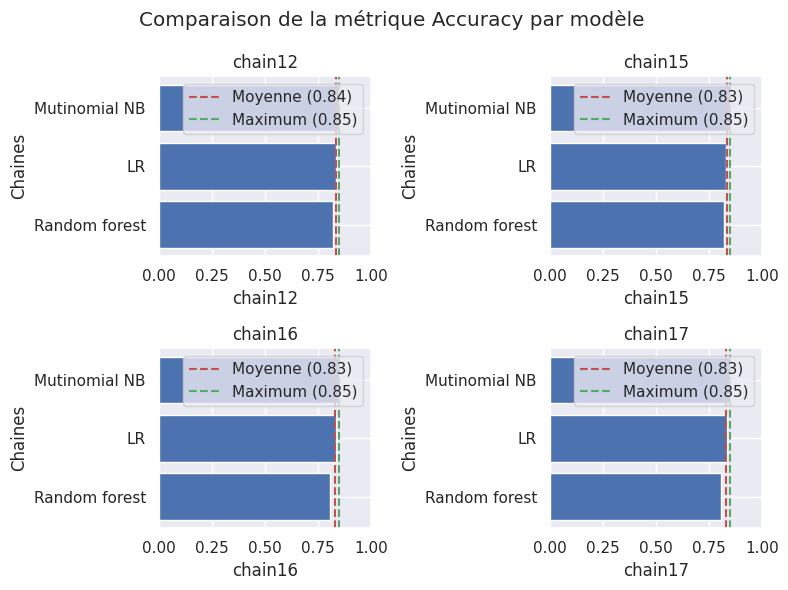

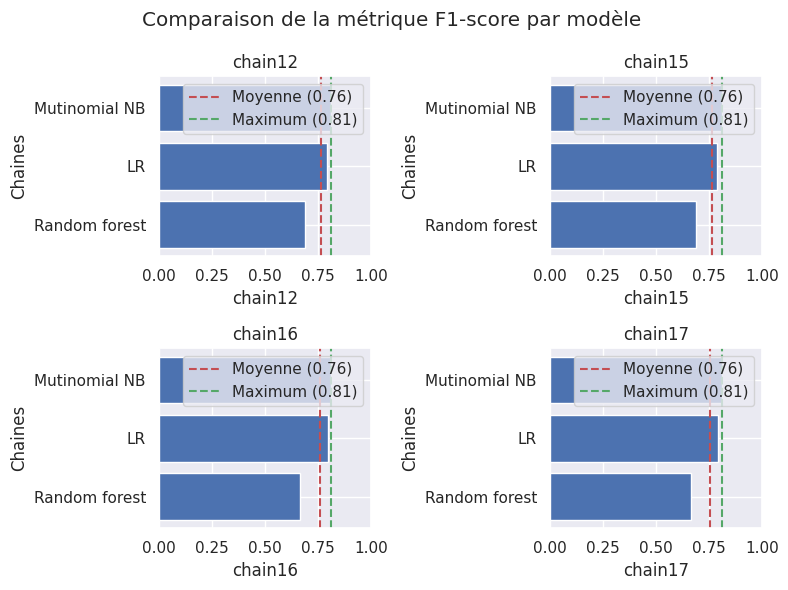

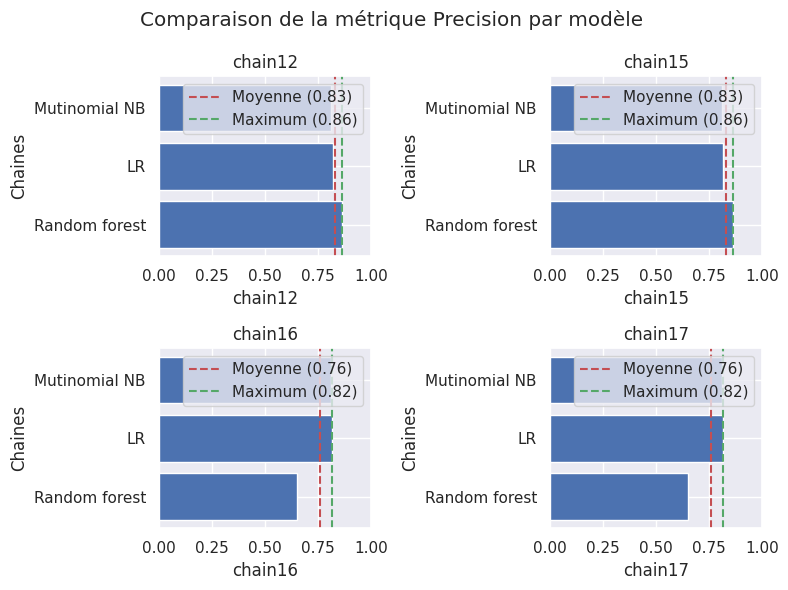

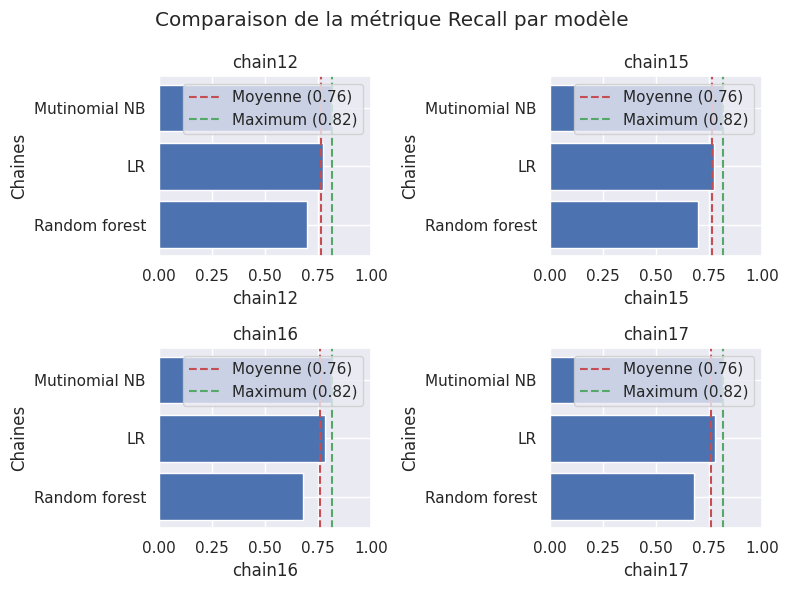

In [49]:
comparer_chaines(classification_reports)

Les chaines 12 et 15 sont légèrement meilleures en terme de précision, on conserve la 12.

## Septièmes chaines 

Le pré-traitement appliqué est :
- Nettoyage du texte : supprimer les caractères spéciaux, les ponctuations, les accents convertir en minuscules
- Tokenisation
- Suppression des mots vides
- Désuffixation
- Lemmatisation

Et on utilise les traits suivants :

| n° | headline | text | 
| --- | --- | --- | 
| 12 |

In [61]:
chaines = [
    ('chain12', ColumnTransformer(
        [
            ('headline_tfidf_010', tfidf_010, 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain18', ColumnTransformer(
        [
            ('headline_tfidf_010', 
                Pipeline(
                 [
                     ('lemmatization',  FunctionTransformer(lemmatization_transformer)),
                     ('text_stats', tfidf_010),
                 ]
                ),
                 'headline'),
            ('text_bow_001',  bow_001, 'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain19', ColumnTransformer(
        [
            ('headline_tfidf_010', tfidf_010, 'headline'),
            ('text_bow_001',  
              Pipeline(
                 [
                     ('lemmatization',  FunctionTransformer(lemmatization_transformer)),
                     ('text_stats', bow_001),
                 ]
                ),
              'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
    
    ('chain20', ColumnTransformer(
        [
            ('headline_tfidf_010', 
                Pipeline(
                 [
                     ('lemmatization',  FunctionTransformer(lemmatization_transformer)),
                     ('text_stats', tfidf_010),
                 ]
                ),
                 'headline'),
            ('text_bow_001',  
              Pipeline(
                 [
                     ('lemmatization',  FunctionTransformer(lemmatization_transformer)),
                     ('text_stats', bow_001),
                 ]
                ),
              'text'),
            (
             'text_stats',
             Pipeline(
                 [
                     ('text_stats', text_stats_transformer),
                     ('vect', text_stats_vectorizer),
                     ('scaling', min_max_scaler)
                 ]
             ),
             'text'
         )
        ]
    )),
]


In [62]:
classification_reports = run(chaines, models)

/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/zoe/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

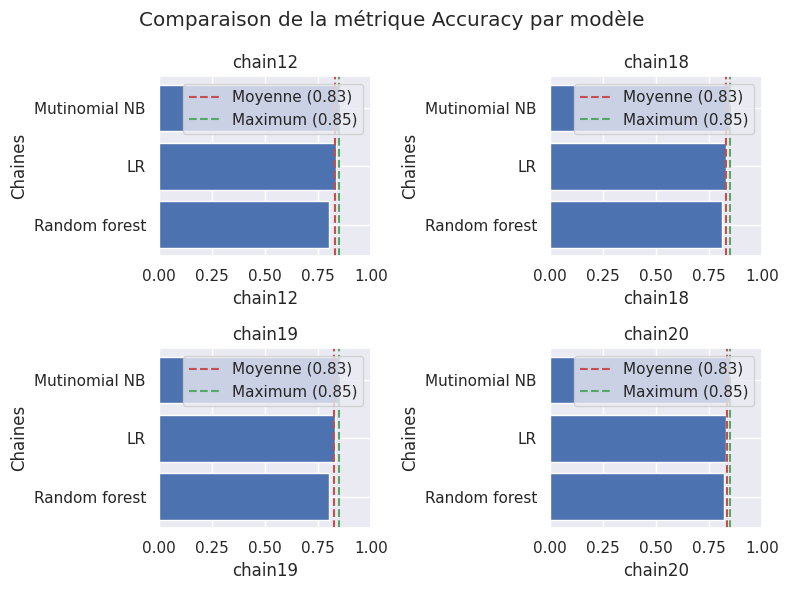

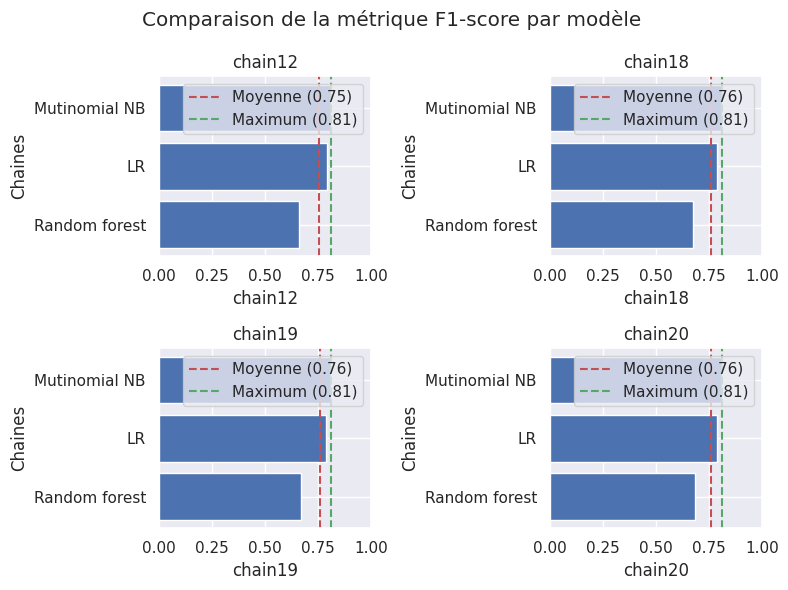

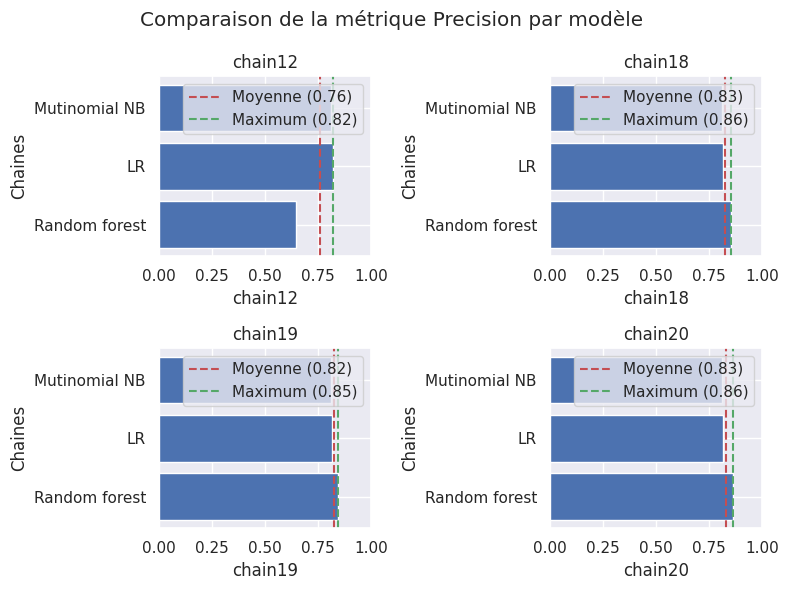

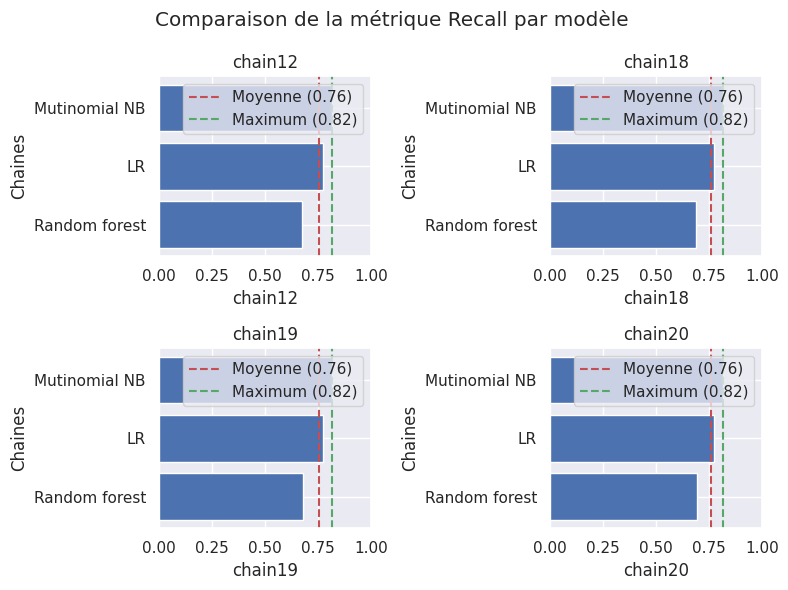

In [63]:
comparer_chaines(classification_reports)

Finalement, on conserve le modèle Multinomial NB car il nous permet de sélectionner l'accuracy et le F1-score maximaux.

Inspection des valeurs pour les 4 chaines :

In [74]:
def round_dict_values(d):
    return {k: round(v, 3) for k, v in d.items()}

print("12",classification_reports["chain12"]["Mutinomial NB"])
print("18",classification_reports["chain18"]["Mutinomial NB"])
print("19",classification_reports["chain19"]["Mutinomial NB"])
print("20",classification_reports["chain20"]["Mutinomial NB"])


12 {'accuracy': 0.849, 'f1-score': 0.813, 'precision': 0.812, 'recall': 0.816}
18 {'accuracy': 0.849, 'f1-score': 0.812, 'precision': 0.811, 'recall': 0.816}
19 {'accuracy': 0.85, 'f1-score': 0.813, 'precision': 0.812, 'recall': 0.817}
20 {'accuracy': 0.85, 'f1-score': 0.813, 'precision': 0.812, 'recall': 0.817}


On sélectionne donc finalement la chaine 19 (scores égaux à 20 mais 20 lemmatise en plus le titre, ce que ne fait pas 19).

La combinaison sélectionnée est donc 
- modèle = Multinomial NB
- traits = 
  - TF-IDF, fréquence 0.1 pour le titre
    - Prétraitement :
      - Nettoyage du texte
      - Tokenisation
      - Suppression des mots vides
  - Sac de mots, fréquence 0.01 pour le texte
    - Prétraitement : 
      - Nettoyage du texte
      - Tokenisation
      - Suppression des mots vides
      - Lemmatisation
  - Informations statistiques sur le texte
    - Longueur du texte en nombre de caractères, nombre de phrases

----

## BiLSTM

In [ ]:
class_names = sorted(df_train.category.unique())
class_names

['business', 'health', 'politics', 'sports', 'technology']

In [ ]:
# On associe à chaque classe un identifiant unique
class_index = {class_names[i]:i for i in range(len(class_names))}
class_index

{'business': 0, 'health': 1, 'politics': 2, 'sports': 3, 'technology': 4}

In [ ]:
# concaténer titre et texte pour avoir un seul input
X_train = X_train.headline + ' ' + X_train.text

In [ ]:
# ici ajouter standardize pour nettoyer les données avant  ?

def get_vectorizer(documents, max_voc_size=8000, max_seq_length=50, batch_size=128):
  vectorizer = TextVectorization( #standardize=split_into_tokens_nltk,
                                max_tokens=max_voc_size,
                                 output_sequence_length=max_seq_length)
  # Création du jeu de données à partir de X_train et constitution de lots de 128 instances
  text_ds = tf.data.Dataset.from_tensor_slices(documents).batch(batch_size)
  # Création du vocabulaire à partir des données d'entrée
  vectorizer.adapt(text_ds)
  return vectorizer

In [ ]:
keras_vectorizer = get_vectorizer(X_train)

2024-04-29 09:40:13.203098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
voc = keras_vectorizer.get_vocabulary()
print(len(voc))

8000


In [ ]:
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Définition des paramètres du modèle
vocab_size = 10000  # Taille du vocabulaire
embedding_dim = 100  # Dimension de l'espace d'embedding
max_length = 100  # Longueur maximale des séquences
num_classes = 10  # Nombre de classes de sortie

# Exemple de données
X_headline = X_train.headline
X_text = X_train.text
y = y_train

In [ ]:
# Tokenisation des données
tokenizer_headline = Tokenizer(num_words=vocab_size)
tokenizer_headline.fit_on_texts(X_headline)
X_headline_seq = tokenizer_headline.texts_to_sequences(X_headline)

tokenizer_text = Tokenizer(num_words=vocab_size)
tokenizer_text.fit_on_texts(X_text)
X_text_seq = tokenizer_text.texts_to_sequences(X_text)

In [ ]:
# Remplissage des séquences pour avoir une longueur uniforme
X_headline_padded = pad_sequences(X_headline_seq, maxlen=max_length, padding='post')
X_text_padded = pad_sequences(X_text_seq, maxlen=max_length, padding='post')

In [ ]:
# Construction du modèle BiLSTM
input_headline = Input(shape=(max_length,))
input_text = Input(shape=(max_length,))

embedding_layer_headline = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_headline)
embedding_layer_text = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_text)

lstm_layer_headline = Bidirectional(LSTM(64))(embedding_layer_headline)
lstm_layer_text = Bidirectional(LSTM(64))(embedding_layer_text)

# Concaténation des sorties BiLSTM
concatenated = tf.keras.layers.concatenate([lstm_layer_headline, lstm_layer_text], axis=-1)

output_layer = Dense(num_classes, activation='softmax')(concatenated)

# Création du modèle
model = Model(inputs=[input_headline, input_text], outputs=output_layer)

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Affichage de la structure du modèle
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  1,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 100)  │  1,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     84,480 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     84,480 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │      2,570 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,171,530 (8.28 MB)

 Trainable params: 2,171,530 (8.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def plot_results(histories):
  accuracy_data = []
  loss_data = []
  for i, h in enumerate(histories):
    acc = h.history['acc']
    val_acc = h.history['val_acc']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    for j in range(len(acc)):
      accuracy_data.append([i+1, j+1, acc[j], 'Entraînement'])
      accuracy_data.append([i+1, j+1, val_acc[j], 'Validation'])
      loss_data.append([i+1, j+1, loss[j], 'Entraînement'])
      loss_data.append([i+1, j+1, val_loss[j], 'Validation'])

  acc_df = pd.DataFrame(accuracy_data,
                        columns=['Pli', 'Epoch', 'Accuracy', 'Données'])
  sns.relplot(data=acc_df, x='Epoch', y='Accuracy', hue='Pli', style='Données',
              kind='line')

  loss_df = pd.DataFrame(loss_data, columns=['Pli', 'Epoch', 'Perte', 'Données'])
  sns.relplot(data=loss_df, x='Epoch', y='Perte', hue='Pli', style='Données',
              kind='line')

## Analyse

## Sur le jeu de test